# **Introduction**

**About Dataset**

* **Breast cancer** is one of the **most common** causes of death among **women worldwide**. Early detection helps in reducing the **number of early deaths**. The data reviews the **medical images of breast cancer** using ultrasound scan. **Breast Ultrasound Dataset** is categorized into **three classes** $:$ **normal, benign, and malignant images**. **Breast ultrasound images** can produce great results in **classification, detection, and segmentation** of breast cancer when combined with machine learning. 

* The data collected at baseline include **breast ultrasound images among women** in ages between 25 and 75 years old. This data was collected in **2018**. The number of patients is **600 female patients**. The dataset consists of **780 images** with an **average image size of 500*500 pixels**. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into **three classes, which are normal, benign, and malignant**.

**Model Architecture**

* Vision Transformer to classify different tumor types
* Mask2Former to identify tumor areas

## **Problem 1**

### **Data Processing**

In [363]:
# data processing 
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random
from torchvision import models

In [257]:
class BreastUltrasoundDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        :param root_dir: 包含子文件夹 ('benign', 'malignant', 'normal') 的根目录路径
        :param transform: 用于图像增强的transform
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # 获取子文件夹名称（即类别名）
        self.class_names = os.listdir(root_dir)
        
        # 存储所有图像的路径
        self.image_paths = []
        for class_name in self.class_names:
            class_folder = os.path.join(root_dir, class_name)
            image_files = [f for f in os.listdir(class_folder) if f.endswith('.png') and '_mask' not in f]
            for img_file in image_files:
                self.image_paths.append((class_name, os.path.join(class_folder, img_file)))

        # 定义标签
        self.label_map = {'normal': 0, 'benign': 1, 'malignant': 2}
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        class_name, img_path = self.image_paths[idx]
        
        # 加载原始图像和mask图像
        image = Image.open(img_path).convert("RGB")
        mask_path = img_path.replace('.png', '_mask.png')  # mask 图像和原始图像同名，只是多了 "_mask"
        mask = Image.open(mask_path).convert("L")  # mask 是单通道图像，L模式
        
        # 获取标签（根据文件夹名推断标签）
        label = self.label_map[class_name]
        
        # 应用数据增强和预处理
        if self.transform:
            image, mask = self.transform(image, mask)
        
        return image, mask, label

In [258]:
def custom_transform(image, mask):
    """
    自定义数据增强和预处理操作。
    
    该函数对输入的图像和掩膜进行一系列变换：
    - 图像进行缩放、随机水平翻转、随机旋转、转为Tensor并进行标准化。
    - 掩膜进行相同的变换（除标准化外），以确保图像和掩膜保持一致。
    
    :param image: 输入的图像（PIL格式）
    :param mask: 对应的掩膜图像（PIL格式），单通道（L模式）
    
    :return: 返回处理后的图像和掩膜（Tensor格式）
    """
    
    # 图像预处理变换
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),  # 将图像缩放到 256x256 尺寸
        transforms.RandomHorizontalFlip(),  # 随机进行水平翻转（50%的概率）
        transforms.RandomRotation(30),  # 随机旋转图像，旋转角度范围为[-30, 30]度
        transforms.ToTensor(),  # 将图像从PIL格式转换为Tensor格式，并且将像素值从[0, 255]标准化到[0, 1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 根据ImageNet的均值和标准差进行归一化
    ])
    
    # 掩膜预处理变换
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),  # 将掩膜缩放到 256x256 尺寸
        transforms.RandomHorizontalFlip(),  # 随机进行水平翻转（50%的概率）
        transforms.RandomRotation(30),  # 随机旋转掩膜，旋转角度范围为[-30, 30]度
        transforms.ToTensor()  # 将掩膜从PIL格式转换为Tensor格式，掩膜通常是单通道图像，值为0或1
    ])
    
    # 应用图像和掩膜的转换
    image = image_transform(image)  # 对图像进行转换
    mask = mask_transform(mask)  # 对掩膜进行转换
    
    return image, mask  # 返回处理后的图像和掩膜


In [259]:
# 创建数据集实例
root_dir = '/data2404/buyf/Class/ai4bio/hw3_4/Dataset_BUSI_with_GT'  # 数据集根目录，包含 bening、malignant 和 normal 文件夹
dataset = BreastUltrasoundDataset(root_dir=root_dir, transform=custom_transform)

In [337]:
# 测试数据集类
image, mask, label = dataset[0]
print(image.shape, mask.shape, label)

torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) 2


In [145]:
from collections import Counter

# 初始化标签计数器
label_counter = Counter()

# 遍历数据集并统计每个标签的数量
for _, _, label in dataset:
    label_counter[label] += 1  # 

# 计算每个标签的比例
total_samples = len(dataset)
label_proportions = {label: count / total_samples for label, count in label_counter.items()}

# 打印标签比例
print("Label proportions:")
for label, proportion in label_proportions.items():
    print(f"Label {label}: {proportion:.4f} ({label_counter[label]} samples)")


Label proportions:
Label 2: 0.2692 (210 samples)
Label 0: 0.1705 (133 samples)
Label 1: 0.5603 (437 samples)


发现数据标签不均衡使用原始数据标签会严重影响分类的效果，因此对训练集采用SMOTE进行数据均衡。

In [98]:
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import numpy as np

In [338]:
# Step 1: 创建一个 DataLoader 用于加载数据
# 将 dataset 划分为训练集和测试集
train_size = int(0.7 * len(dataset))  # 70% 用于训练
remaining_size = len(dataset) - train_size  # 剩余 30%
val_size = int(0.5 * remaining_size)  # 剩余的 30% 中的一半用于验证集
test_size = remaining_size - val_size  # 另一半用于测试集

train_dataset, remaining_dataset = random_split(dataset, [train_size, remaining_size])
val_dataset, test_dataset = random_split(remaining_dataset, [val_size, test_size])

In [339]:
# Step 2: 采用SMOTE进行数据标签均衡
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset

# 提取训练数据和标签
train_images = []
train_labels = []

for images, masks, labels in train_dataset:
    train_images.append(images.numpy())
    train_labels.append(labels)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# 将数据展平以适应 SMOTE
n_samples, n_channels, height, width = train_images.shape
train_images_flat = train_images.reshape((n_samples, -1))

# 使用 SMOTE 进行过采样
smote = SMOTE(random_state=42)
train_images_resampled, train_labels_resampled = smote.fit_resample(train_images_flat, train_labels)

# 将数据恢复到原始形状
train_images_resampled = train_images_resampled.reshape((-1, n_channels, height, width))

# 转换为 Tensor
train_images_resampled = torch.tensor(train_images_resampled, dtype=torch.float32)
train_labels_resampled = torch.tensor(train_labels_resampled, dtype=torch.long)

# 创建新的训练数据集
train_dataset_resampled = TensorDataset(train_images_resampled, train_labels_resampled)

# 创建 DataLoader
train_loader_resampled = DataLoader(train_dataset_resampled, batch_size=32, shuffle=True)

In [340]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [341]:
# Step 3: 创建 DataLoader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### **Model Architect : Vision Transformer**

In [342]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [343]:
class PreNorm(nn.Module):
    def __init__(self, emb_size, fn):
        super().__init__()
        self.norm = nn.LayerNorm(emb_size)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [344]:
class FeedForward(nn.Module):
    def __init__(self, emb_size, hidden_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_size, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, emb_size), 
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [346]:
class Attention(nn.Module):              
    def __init__(self, emb_size, num_heads=12, dim_head=64, dropout=0.1):
        super().__init__()
        
        # 计算内部维度
        inner_dim = dim_head * num_heads

        self.heads = num_heads  # 注意力头的数量
        self.scale = dim_head ** -0.5  # 缩放因子，用于稳定点积注意力的计算

        # Softmax层，用于计算注意力权重
        self.attend = nn.Softmax(dim=-1)
        # 用于生成查询、键、值的线性变换
        self.to_qkv = nn.Linear(emb_size, inner_dim * 3, bias=False)

        # 输出层，进行最终的线性变换和dropout
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, emb_size),
            nn.Dropout(dropout),
        ) 

    def forward(self, x):
        # 获取输入的批量大小、序列长度和特征维度
        b, n, _, h = *x.shape, self.heads
    
        # 将输入x转换为查询、键和值
        qkv = self.to_qkv(x).chunk(3, dim=-1)  # 将输出分成q、k、v三部分
        # 重排q、k、v，使其形状为 (b, h, n, dim_head)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        # DropKey操作：随机丢弃部分键和值
        if self.training:  # 仅在训练时应用DropKey
            drop_prob = 0.1  # 设置丢弃概率
            mask = (torch.rand((b, h, n)) > drop_prob).float()  # 生成掩码
            k = k * mask.unsqueeze(-1)  # 应用掩码到键
            v = v * mask.unsqueeze(-1)  # 应用掩码到值

        # 计算注意力权重
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale  # 计算点积并缩放

        attn = self.attend(dots)  # 计算注意力权重

        # 应用注意力权重到值上
        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        # 重排输出，使其形状为 (b, n, h * dim_head)
        out = rearrange(out, 'b h n d -> b n (h d)')
    
        return self.to_out(out)  # 最后通过输出层


In [347]:
class Transformer(nn.Module):
    def __init__(self, emb_size, num_layers, num_heads, dim_head, mlp_dim, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                PreNorm(emb_size, Attention(emb_size, num_heads=num_heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(emb_size, FeedForward(emb_size, mlp_dim, dropout=dropout))
            ]))
    
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [348]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=256, patch_size=16, num_classes=3, emb_size=1024, num_heads=12, dim_head=64, num_layers=6, mlp_dim=2048, dropout=0.1):
        """
        :param img_size: 图像的大小 (默认为256x256)
        :param patch_size: 每个 patch 的大小 (默认为16x16)
        :param num_classes: 输出类别数 (默认为86，用于分类任务)
        :param emb_size: Transformer 的 embedding 大小 (默认为768)
        :param num_heads: Transformer 中的注意力头数
        :param num_layers: Transformer 中的层数
        :param mlp_dim: MLP 层的维度
        :param dropout: dropout rate
        """
        super(VisionTransformer, self).__init__()

        # 图像分块（patch embedding）
        self.patch_size = patch_size
        self.img_size = img_size
        self.num_patches = (img_size // patch_size) ** 2

        # patch embedding: 将每个 patch 扁平化并映射到一个高维向量
        self.patch_embedding = nn.Conv2d(in_channels=3, out_channels=emb_size, kernel_size=patch_size, stride=patch_size)

        # Class Token 用于表示图像的整体表示
        self.class_token = nn.Parameter(torch.zeros(1, 1, emb_size))

        # Positional Encoding
        self.position_encoding = nn.Parameter(torch.zeros(1, self.num_patches + 1, emb_size))

        # Transformer 层
        self.transformer = Transformer(emb_size, num_layers, num_heads, dim_head, mlp_dim, dropout=0.1)

        # 最后一个 MLP 层，用于分类
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, num_classes)
        )

    def forward(self, x):
        # 将图像转换为 patches，并添加 class token 和位置编码
        x = self.patch_embedding(x)  # 输出形状为 (batch_size, emb_size, num_patches_h, num_patches_w)
        x = x.flatten(2).transpose(1, 2)  # 将形状转换为 (batch_size, num_patches, emb_size)
        
        # 加上 class token 和位置编码
        class_tokens = self.class_token.expand(x.size(0), -1, -1)
        x = torch.cat((class_tokens, x), dim=1)
        x = x + self.position_encoding
        
        # 通过 Transformer 层
        x = self.transformer(x)

        # 获取 class token 输出并进行分类
        x = x[:, 0]  # 选择第一个位置，作为整体图像表示
        x = self.mlp_head(x)  # (batch_size, num_classes)

        return x


基于 Vision Transformer（ViT）的图像分类模型，其架构包含以下几个关键部分：

1. **图像分块 (Patch Embedding)**：首先，输入的图像被分成固定大小的块（patches）。每个块被卷积操作扁平化，并映射到一个高维的嵌入空间，这个嵌入空间的维度由 `emb_size` 控制。通过卷积操作，每个块的空间信息被保留，并将图像转换为一组固定大小的向量。

2. **Class Token 和位置编码 (Positional Encoding)**：为了捕捉整个图像的上下文信息，模型引入了一个 **Class Token**，它代表整个图像的表示，类似于 BERT 中的 [CLS] token。位置编码则用于注入输入块的位置信息，从而使模型能够理解块之间的空间关系。位置编码被加到每个图像块的嵌入上。

3. **Transformer 层**：这些嵌入（包含 class token 和位置编码）被传入多个 Transformer 层进行处理。Transformer 层由多头自注意力机制和多层感知机（MLP）组成，能够有效捕捉图像块之间的复杂关系。注意力机制使得每个图像块能够与其他图像块的信息进行交互，从而形成更丰富的特征表示。

4. **分类头 (Classification Head)**：通过 Transformer 层处理后，模型取出 **Class Token** 的输出作为整个图像的表示。最后，经过一个 **MLP 层**（包含 `LayerNorm` 和 `Linear` 层）进行分类，输出最终的分类结果。

该模型的优势在于它能够处理大尺寸的图像，并通过 Transformer 强大的建模能力捕捉图像全局的语义信息，尤其适用于图像分类任务。

In [349]:
# 实例化 VisionTransformer 模型
model = VisionTransformer(img_size=256, patch_size= 32, num_classes=3, emb_size= 256, 
                          num_heads= 6, dim_head= 32, num_layers= 3, mlp_dim= 256, dropout=0.1)

实例化 `VisionTransformer` 模型将图像大小设置为 `256x256`，每个 patch 大小为 `32x32`，适用于 3 类分类任务。每个 patch 被嵌入到一个 256 维的向量中，使用 6 个自注意力头（每个头的维度为 32）和 3 层 Transformer 层进行特征提取。前馈网络（MLP）的隐藏层维度为 256，使用 10% 的 dropout 进行正则化，同时10%的dropKey防止过拟合。

In [66]:
from tensorboardX import SummaryWriter
import torch

# 创建一个假输入（模拟输入数据）
input_image = torch.randn(1, 3, 256, 256)  # Batch size 为 1 的输入

# 创建 SummaryWriter，用于将数据写入 TensorBoard
writer = SummaryWriter()

# 传入模型和输入数据
writer.add_graph(model, input_image)

# 关闭 SummaryWriter
writer.close()

# 启动 TensorBoard：在终端运行 `tensorboard --logdir runs`

采用TensorBoard查看模型架构。

### **Train Vision Transformer**

In [350]:
import torch.optim as optim
import torch.nn as nn
import logging

In [351]:
# 初始化日志
logging.basicConfig(filename="training_log.txt", level=logging.INFO)
logging.info("Epoch\tTrain Loss\tTrain Accuracy")


In [352]:
# 选择损失函数和优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# 使用学习率调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

In [353]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # 控制类别平衡
        self.gamma = gamma  # 调整难易样本的惩罚程度
        self.reduction = reduction  # 'mean' or 'sum'

    def forward(self, inputs, targets):
        # 输入 (inputs) 是模型的输出 logits (未经过 softmax)
        # 目标 (targets) 是标签的索引（0, 1, ..., C-1）

        # 计算交叉熵损失
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # 计算每个样本的预测概率
        pt = torch.exp(-BCE_loss)  # pt 是样本被正确分类的概率
        
        # 计算焦点损失
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


为了减少数据标签不均衡对模型效果，使用FocalLoss更多的关注数量少的样本类型，赋予更大的损失权重。

In [ ]:
# 训练模型
num_epochs = 50  # 最多训练50个epoch
# 设置早停参数，防止过拟合
patience = 5  # 允许验证集损失无改善的最大 epoch 数
best_loss = float("inf")  # 初始最好的损失设为无穷大
counter = 0  # 当前没有改善的 epoch 数
best_model_state = None  # 保存最优模型

for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0
    criterion = FocalLoss(alpha=1.0, gamma=2.0, reduction='mean')  # 可以根据需要调整 alpha 和 gamma
    # criterion = nn.CrossEntropyLoss()
    
    # 训练集
    for images, labels in train_loader_resampled:
        optimizer.zero_grad()  # 清空梯度
        
        # 前向传播
        outputs = model(images)  # 得到分类结果（logits）
        
        # 计算损失
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 计算分类准确率
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # 每个epoch的训练损失和准确率
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    
    # 输出日志文件
    logging.info(f"{epoch+1}\t{epoch_loss:.4f}\t{epoch_acc:.2f}%")

    # 打印训练日志
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # 验证集（用于早停判断）
    model.eval()  # 设置模型为评估模式
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    # criterion = FocalLoss(alpha=10.0, gamma=2.0, reduction='mean')  # 可以根据需要调整 alpha 和 gamma
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():  # 不计算梯度
        for images, masks, labels in val_loader:
            labels = labels.long()

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # 计算验证集准确率
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total * 100
    
    # 记录学习率
    scheduler.step(val_loss)

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # Step 4: 判断早停和保存最优模型
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0  # 如果损失有改善，则重置counter
        best_model = model
    else:
        counter += 1  # 如果损失没有改善，增加counter

    # 如果连续若干个epoch没有改善，则提前停止
    if counter >= patience:
        print(f"Early stopping after epoch {epoch+1}")
        break

# 保存整个最优模型（结构和权重）
if best_model is not None:
    torch.save(best_model, 'best_model_full.pth')
    print("Best model saved as 'best_model_full.pth'")

Epoch [1/50], Loss: 0.6224, Accuracy: 34.87%
Validation Loss: 1.0524, Accuracy: 50.43%
Epoch [2/50], Loss: 0.4934, Accuracy: 41.01%
Validation Loss: 1.0169, Accuracy: 52.14%
Epoch [3/50], Loss: 0.4675, Accuracy: 41.89%
Validation Loss: 1.0817, Accuracy: 35.04%
Epoch [4/50], Loss: 0.4515, Accuracy: 47.48%
Validation Loss: 1.1313, Accuracy: 28.21%
Epoch [5/50], Loss: 0.4387, Accuracy: 47.70%
Validation Loss: 0.9894, Accuracy: 41.03%
Epoch [6/50], Loss: 0.4195, Accuracy: 49.89%
Validation Loss: 1.0670, Accuracy: 38.46%
Epoch [7/50], Loss: 0.3881, Accuracy: 57.24%
Validation Loss: 1.0161, Accuracy: 41.88%
Epoch [8/50], Loss: 0.3711, Accuracy: 55.81%
Validation Loss: 0.9974, Accuracy: 42.74%
Epoch [9/50], Loss: 0.3447, Accuracy: 61.07%
Validation Loss: 1.0530, Accuracy: 38.46%
Epoch [10/50], Loss: 0.2953, Accuracy: 65.35%
Validation Loss: 0.8612, Accuracy: 58.12%
Epoch [11/50], Loss: 0.2616, Accuracy: 68.86%
Validation Loss: 0.8935, Accuracy: 54.70%
Epoch [12/50], Loss: 0.2426, Accuracy: 71

### **Test Vision Transformer**

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Test Accuracy: 58.12%


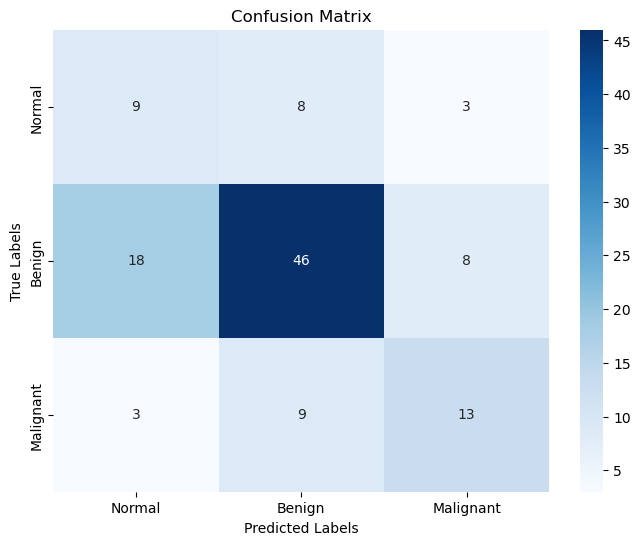

In [ ]:
# 加载最优模型
best_model = torch.load('best_model_full.pth',weights_only= False)
best_model.eval()  # 设置为评估模式

# 在测试集上评估模型
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, masks, labels in test_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 存储标签和预测结果以绘制混淆矩阵
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.2f}%")

# Step 3: 计算混淆矩阵
conf_matrix = confusion_matrix(all_labels, all_preds)

# Step 4: 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Benign", "Malignant"], yticklabels=["Normal", "Benign", "Malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Vision Transformer在训练过程中遇到不少困难，导致模型效果不理想：

1. **样本标签不均衡问题**，导致模型会数量少的Normal，Malignant预测成为Benign，尽管采用FocalLoss，但是效果依旧不理想，最后使用SMOTE进行过采样使得三种类型的样本数量基本一致使得这个问题得以缓解（由最后的混淆矩阵可以看出，Normal，Malignant部分样本预测正确，未过采样前所有的Normal，Malignant都会被预测成为Benign），但是在训练集上进行过采样使得样本标签均衡后，在验证集和测试集上模型效果依旧不理想。
   
2. **模型过拟合问题**，由于数据集比较少，不适合在标准的Vision Transformer直接进行训练，因此采取了一下措施：
   1. model = VisionTransformer(img_size=256, patch_size= 32, num_classes=3, emb_size= 256, num_heads= 6, dim_head= 32, num_layers= 3, mlp_dim= 256, dropout=0.1)，经过几次调参发现降低emb_size，num_heads，num_layers和 mlp_dim可以防止过拟合效果明显，将这几个参数进行了大幅度的下调（相比于标准版Vision Transformer）
   2. 查阅文献发现 dropkey，在进行注意力机制的计算过程中随意丢失部分key有防止过拟合效果（但是此问题中效果不太明显
   3. 设置早停机制
   
整个调参过程尝试不少参数变动，但最后模型的效果依旧不是很理想，test_accuracy不到60%。

### **Basic Model : MLP**

In [289]:
class MLPClassifier(nn.Module):
    def __init__(self, input_channels=3, img_size=256, num_classes=3, hidden_layers=[512, 256, 128],dropout=0.1):
        """
        :param input_channels: 输入图像的通道数，默认为3（RGB图像）
        :param img_size: 图像的大小，默认为 256x256
        :param num_classes: 输出类别数
        :param hidden_layers: 一个列表，定义隐藏层的大小
        """
        super(MLPClassifier, self).__init__()
        
        # 定义卷积层
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # 扁平化后的图像大小
        self.fc_input_size = 64 * (img_size // 4) * (img_size // 4)  # 假设经过两层卷积后尺寸会减少为原来的1/4
        
        # 定义MLP层
        layers = []
        in_features = self.fc_input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))  # 添加Dropout以防止过拟合
            layers.append(nn.BatchNorm1d(hidden_size))  # 添加BatchNorm
            in_features = hidden_size
        
        layers.append(nn.Linear(in_features, num_classes))  # 输出层
        
        # 将所有层组合成一个顺序容器
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        # 通过卷积层
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)  # 使用最大池化，减少尺寸
        
        # print(f"After conv1 and pool1: {x.shape}")  # 打印conv1后输出的尺寸
        
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)  # 使用最大池化，减少尺寸
        
        # print(f"After conv2 and pool2: {x.shape}")  # 打印conv2后输出的尺寸

        # 展平卷积层的输出
        x = x.view(x.size(0), -1)  # (batch_size, flattened_size)
        
        # print(f"After flatten: {x.shape}")  # 打印展平后的输出尺寸
        
        # 通过MLP层
        x = self.mlp(x)
        
        return x

In [290]:
#实例化MLP模型
model = MLPClassifier(input_channels=3, img_size=256, num_classes=3, hidden_layers=[512, 256, 128],dropout=0.1)

基础模型采用的MLP模型，输入图像经过两层卷积层，每层后接ReLU激活函数和最大池化层，用于提取低级特征并减小空间维度。接着，卷积层输出的特征图被展平成一维向量，输入到MLP部分。MLP由三个全连接层组成，每层后加入ReLU激活函数、Dropout层（用于防止过拟合）和BatchNorm层（提升训练稳定性）。最终，通过一个全连接层输出类别预测。该架构通过卷积层提取图像特征，再通过MLP进行高级特征融合和分类，适用于图像分类任务。

In [280]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
# 设置 L2 正则化的系数
l2_lambda = 0.1  # 你可以根据需要调整这个值
# 使用 Adam 优化器，设置 weight_decay 为 L2 正则化系数
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=l2_lambda)
#使用学习率调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

In [291]:
# 训练模型
num_epochs = 50  # 最多训练50个epoch
# 设置早停参数，防止过拟合
patience = 5  # 允许验证集损失无改善的最大 epoch 数
best_loss = float("inf")  # 初始最好的损失设为无穷大
counter = 0  # 当前没有改善的 epoch 数
best_model = None  # 保存最优模型

for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 训练集
    for images, labels in train_loader_resampled:
        optimizer.zero_grad()  # 清空梯度
        
        # 前向传播
        outputs = model(images)  # 得到分类结果（logits）
        
        # 计算损失
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 计算分类准确率
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # 每个epoch的训练损失和准确率
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    
    # 打印训练日志
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # 验证集（用于早停判断）
    model.eval()  # 设置模型为评估模式
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # 不计算梯度
        for images, masks, labels in val_loader:
            labels = labels.long()

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # 计算验证集准确率
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total * 100
    
    # 记录学习率
    scheduler.step(val_loss)

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # Step 4: 判断早停和保存最优模型
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0  # 如果损失有改善，则重置counter
        best_model = model
    else:
        counter += 1  # 如果损失没有改善，增加counter

    # 如果连续若干个epoch没有改善，则提前停止
    if counter >= patience:
        print(f"Early stopping after epoch {epoch+1}")
        break

# 保存整个最优模型（结构和权重）
if best_model is not None:
    torch.save(best_model, 'best_MLP_model_full.pth')
    print("Best model saved as 'best_MLP_model_full.pth'")

Epoch [1/50], Loss: 1.2448, Accuracy: 33.76%
Validation Loss: 1.1040, Accuracy: 28.21%
Epoch [2/50], Loss: 1.2568, Accuracy: 33.44%
Validation Loss: 1.1320, Accuracy: 35.90%
Epoch [3/50], Loss: 1.2153, Accuracy: 35.44%
Validation Loss: 1.1011, Accuracy: 42.74%
Epoch [4/50], Loss: 1.2335, Accuracy: 35.34%
Validation Loss: 1.1451, Accuracy: 37.61%
Epoch [5/50], Loss: 1.2434, Accuracy: 34.92%
Validation Loss: 1.1672, Accuracy: 29.06%
Epoch [6/50], Loss: 1.2548, Accuracy: 34.81%
Validation Loss: 1.1579, Accuracy: 32.48%
Epoch [7/50], Loss: 1.2363, Accuracy: 35.13%
Validation Loss: 1.0836, Accuracy: 41.03%
Epoch [8/50], Loss: 1.2673, Accuracy: 32.17%
Validation Loss: 1.1402, Accuracy: 36.75%
Epoch [9/50], Loss: 1.2387, Accuracy: 33.86%
Validation Loss: 1.1049, Accuracy: 38.46%
Epoch [10/50], Loss: 1.2496, Accuracy: 33.23%
Validation Loss: 1.1104, Accuracy: 44.44%
Epoch [11/50], Loss: 1.2545, Accuracy: 35.13%
Validation Loss: 1.0877, Accuracy: 40.17%
Epoch [12/50], Loss: 1.2611, Accuracy: 34

Test Accuracy: 35.90%


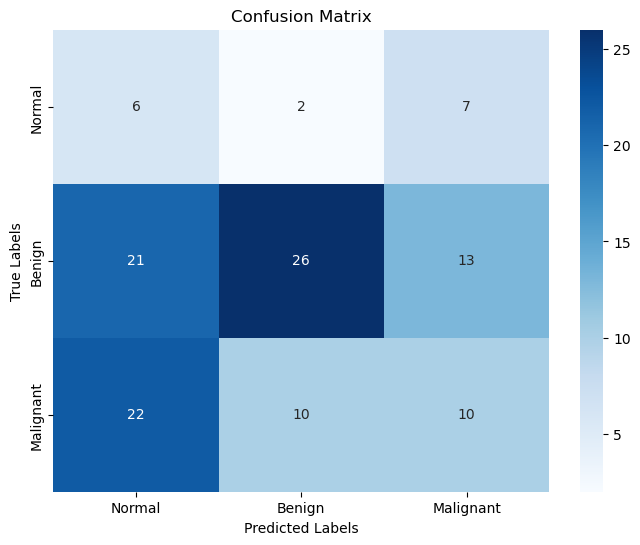

In [292]:
# 加载最优模型
best_model = torch.load('best_MLP_model_full.pth',weights_only= False)
best_model.eval()  # 设置为评估模式

# 在测试集上评估模型
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, masks, labels in test_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 存储标签和预测结果以绘制混淆矩阵
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.2f}%")

# Step 3: 计算混淆矩阵
conf_matrix = confusion_matrix(all_labels, all_preds)

# Step 4: 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Benign", "Malignant"], yticklabels=["Normal", "Benign", "Malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


比较经典的模型MLP和Vision Tranformer，后者还是效果更好一些，MLP最后在测试集上的表现仅有36%（略高于33.3%，感觉MLP没学到东西，可见简单的MLP并不适合图像分类任务），Attention机制还是优于简单的MLP。

## **Problem 2**

### **Data Processing**

In [385]:
# 定义图像增强和标准化
def custom_transform(image, mask):
    # 对图像进行处理：包括大小调整、随机水平翻转、随机旋转和标准化
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),  # 调整图像大小
        transforms.RandomHorizontalFlip(),  # 随机水平翻转
        transforms.RandomRotation(30),  # 随机旋转
        transforms.ToTensor(),  # 转换为Tensor并归一化到[0, 1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet的均值和标准差
    ])
    
    # 对掩膜进行处理：包括大小调整、随机水平翻转、随机旋转
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),  # 调整掩膜大小
        transforms.RandomHorizontalFlip(),  # 随机水平翻转
        transforms.RandomRotation(30),  # 随机旋转
        transforms.ToTensor()  # 转换为Tensor
    ])
    
    # 图像增强
    image = image_transform(image)
    mask = mask_transform(mask)
    
    mask = torch.round(mask)  # 将值四舍五入为 0 或 1
    
    # 返回处理后的图像和掩膜
    return image, mask

In [386]:
# 定义数据集类
class BreastUltrasoundDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        :param root_dir: 包含子文件夹 ('benign', 'malignant', 'normal') 的根目录路径
        :param transform: 用于图像增强的transform
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # 获取子文件夹名称（即类别名）
        self.class_names = os.listdir(root_dir)
        
        # 存储所有图像的路径
        self.image_paths = []
        for class_name in self.class_names:
            class_folder = os.path.join(root_dir, class_name)
            image_files = [f for f in os.listdir(class_folder) if f.endswith('.png') and '_mask' not in f]
            for img_file in image_files:
                self.image_paths.append((class_name, os.path.join(class_folder, img_file)))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        class_name, img_path = self.image_paths[idx]
        
        # 加载原始图像和mask图像
        image = Image.open(img_path).convert("RGB")
        mask_path = img_path.replace('.png', '_mask.png')  # mask 图像和原始图像同名，只是多了 "_mask"
        mask = Image.open(mask_path).convert("L")  # mask 是单通道图像，L模式
        
        # 应用数据增强和预处理
        if self.transform:
            image, mask = self.transform(image, mask)
        
        # 将 mask 转换为长整型标签 (B, H, W) 维度并确保是整数
        mask = mask.squeeze(0).long()  # 去掉单通道维度并转换为 long 类型

        return image, mask

In [387]:
# 创建数据集实例
root_dir = '/data2404/buyf/Class/ai4bio/hw3_4/Dataset_BUSI_with_GT'  # 数据集根目录，包含 bening、malignant 和 normal 文件夹
dataset = BreastUltrasoundDataset(root_dir=root_dir,transform=custom_transform)

In [388]:
image, mask = dataset[0]
print(image.shape, mask.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


In [389]:
#创建一个 DataLoader 用于加载数据
# 将 dataset 划分为训练集和测试集
train_size = int(0.8 * len(dataset))  # 80% 用于训练
test_size = len(dataset) - train_size  # 另一半用于测试集

train_dataset, test_dataset = random_split(dataset, [train_size,test_size])

In [390]:
# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### **Model Architect :Mask2Former**

In [391]:
class Mask2Former(nn.Module):
    def __init__(self, num_classes=2, embed_dim=256, num_heads=8, num_layers=6):
        super(Mask2Former, self).__init__()

        # Backbone: 使用预训练的 ResNet-50 提取图像特征
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        # 去掉 ResNet50 的最后两层（全连接层和池化层），只保留特征提取部分
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  
        
        # 添加一个卷积层将 ResNet 输出的 2048 通道调整为 embed_dim
        self.conv = nn.Conv2d(2048, embed_dim, kernel_size=1)
        
        # Transformer Encoder
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=2048, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        # Decoder，用于生成每个实例的掩膜
        self.mask_head = nn.Sequential(
            nn.Conv2d(embed_dim, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )
        
    def forward(self, x):
        # Step 1: 使用 Backbone 提取特征
        features = self.backbone(x)  # 特征图 (B, 2048, H, W)

        # Step 2: 通过一个卷积层调整通道数为 embed_dim
        features = self.conv(features)  # 特征图 (B, embed_dim, H, W)
        
        # Step 3: 通过 Transformer Encoder 对特征进行处理
        B, C, H, W = features.size()
        features = features.flatten(2).permute(2, 0, 1)  # (H*W, B, embed_dim) -> Flatten (H*W) 和 Batches
        encoded_features = self.encoder(features)  # (H*W, B, embed_dim)

        # Step 4: 将编码器输出转换回图像空间
        decoded_features = encoded_features.permute(1, 2, 0).reshape(B, C, H, W)

        # Step 5: 通过掩膜头（Mask Head）生成掩膜
        mask = self.mask_head(decoded_features)  # 输出掩膜 (B, num_classes, H, W)
        
        # Step 6: 上采样使输出与目标掩膜的大小匹配
        mask = F.interpolate(mask, size=(256, 256), mode='bilinear', align_corners=False)
        
        return mask


使用`Mask2Former` 简化版，一个基于 Transformer 的图像分割模型，结合了卷积神经网络和自注意力机制，架构分为以下几个步骤：

1. **Backbone：** 使用预训练的 ResNet-50 提取图像的特征，并去除其最后两层（全连接层和池化层），保留用于特征提取的部分。通过卷积层将 ResNet 输出的 2048 个通道调整为指定的 `embed_dim`（如 256）。

2. **Transformer Encoder：** 将提取到的特征图输入到 Transformer 编码器中，编码器层使用了多头自注意力机制和前馈神经网络来处理图像特征，增强图像的全局上下文信息。该部分是模型的核心，能够有效捕捉长距离的空间依赖关系。

3. **Mask Head：** 在解码阶段，通过卷积层将编码后的特征转换为掩膜图像，最后生成每个实例的预测掩膜。

4. **上采样：** 输出的掩膜图像经过上采样，调整为目标尺寸（如 256x256），以便与真实标签的尺寸匹配。

这种设计结合了卷积神经网络的局部特征提取能力和 Transformer 的全局建模能力，适用于复杂的实例分割任务。

### **Train Model**

In [392]:
# 定义模型、损失函数和优化器
model = Mask2Former(num_classes=2, embed_dim=256, num_heads=8, num_layers=6)
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [393]:
# 训练循环
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, masks in train_loader:
        images = images
        masks = masks
        
        # 模型前向传播
        outputs = model(images)  # 获取掩膜输出
        
        # 计算损失
        loss = criterion(outputs, masks)  # CrossEntropyLoss 需要整数标签
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/20], Loss: 0.2853
Epoch [2/20], Loss: 0.2246
Epoch [3/20], Loss: 0.2030
Epoch [4/20], Loss: 0.1771
Epoch [5/20], Loss: 0.1671
Epoch [6/20], Loss: 0.1631
Epoch [7/20], Loss: 0.1593
Epoch [8/20], Loss: 0.1505
Epoch [9/20], Loss: 0.1438
Epoch [10/20], Loss: 0.1420
Epoch [11/20], Loss: 0.1372
Epoch [12/20], Loss: 0.1335
Epoch [13/20], Loss: 0.1300
Epoch [14/20], Loss: 0.1300
Epoch [15/20], Loss: 0.1324
Epoch [16/20], Loss: 0.1283
Epoch [17/20], Loss: 0.1262
Epoch [18/20], Loss: 0.1263
Epoch [19/20], Loss: 0.1249
Epoch [20/20], Loss: 0.1237


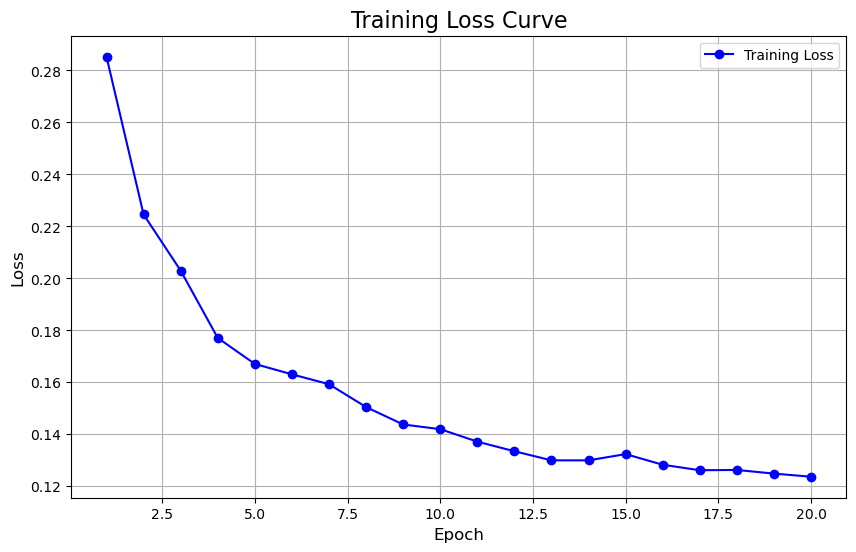

In [394]:
epochs = list(range(1, 21))

losses = [
    0.2853, 0.2246, 0.2030, 0.1771, 0.1671, 0.1631, 0.1593, 0.1505, 0.1438, 0.1420, 
    0.1372, 0.1335, 0.1300, 0.1300, 0.1324, 0.1283, 0.1262, 0.1263, 0.1249, 0.1237
]

# 绘制训练损失曲线
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', color='b', linestyle='-', label='Training Loss')

# 设置标题和标签
plt.title('Training Loss Curve', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
# 添加网格
plt.grid(True)
# 显示图例
plt.legend()
# 显示图像
plt.show()

可以看到20个Epoch比较合理，Training loss波动下降，在17~20进入平滑波动,下降速度缓慢的阶段，说明模型已经训练完成。

### **Test Model**

In [383]:
# 定义评价指标：IoU 和 Dice 系数
def iou_score(pred, target, num_classes):
    iou = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        intersection = torch.sum((pred == cls) & (target == cls)).item()
        union = torch.sum((pred == cls) | (target == cls)).item()
        iou.append(intersection / (union + 1e-6))  # 加上小的常数防止除零错误
    return np.mean(iou)

def dice_score(pred, target, num_classes):
    dice = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    for cls in range(num_classes):
        intersection = torch.sum((pred == cls) & (target == cls)).item()
        dice.append(2 * intersection / (torch.sum(pred == cls).item() + torch.sum(target == cls).item() + 1e-6))
    return np.mean(dice)

IoU(Intersection over Union)评估预测区域与实际区域重叠程度的指标,IoU 值越高，预测区域和实际区域重叠越多，模型的预测效果越好；Dice Score （(Dice Similarity Coefficient, DSC)）是另一种衡量预测区域与真实区域相似度的指标，与 IoU 相比，Dice Score 给重叠部分赋予了更大的权重，因此它通常对小的重叠区域更加敏感。

In [ ]:
#测试模型
model.eval()  # 设置为评估模式
running_iou = 0.0
running_dice = 0.0
total_samples = 0

with torch.no_grad():  # 不需要梯度计算
    for images, masks in test_loader:
        # 前向传播：获取模型预测结果
        outputs = model(images)  # 输出 (B, num_classes, H, W)

        # 使用最大值分类输出（从概率图中选择每个像素最大概率的类别）
        pred = torch.argmax(outputs, dim=1)  # 获取预测类别 (B, H, W)

        # 计算IoU和Dice系数
        iou = iou_score(pred, masks, 2)
        dice = dice_score(pred, masks, 2)

        running_iou += iou
        running_dice += dice
        total_samples += 1

avg_iou = running_iou / total_samples
avg_dice = running_dice / total_samples

print(f"Average IoU: {avg_iou:.4f}")
print(f"Average Dice Score: {avg_dice:.4f}")


Average IoU: 0.6334
Average Dice Score: 0.7259


简化版的Mask2Former整体表现效果较好，IoU和Dice Score均超过60%。

## **Additional Question**

这个数据集存在以下几个问题：

1. **重复图像**：共有155张图像（占数据集的19%）是重复图像或相似图像.

2. **不相关的图像结构**：70张图像（占数据集的8%以上）显示的是与乳腺无关的其他结构，这些图像不符合乳腺超声图像的标准。

3. **病变类型不明确**：至少有19张图像（占数据集的2%以上）病变类型（正常、良性、恶性）存在疑问，这影响了其分类的准确性。

4. **区域内的注释**：许多图像在感兴趣区域内包含注释（如尺寸、描述等），这些注释可能干扰分析。去除这些注释后，剩余有效图像为399张。


In [314]:
# 给定的重复编号集合
duplicate_pairs = [
    {1, 318}, {2, 319}, {3, 320}, {4, 321}, {5, 322}, {6, 323}, {7, 324}, {8, 325}, {9, 326}, {10, 327},
    {11, 328}, {12, 329}, {13, 330}, {14, 331}, {15, 332}, {16, 151}, {17, 425}, {18, 152}, {19, 150},
    {21, 154}, {25, 153}, {30, 128}, {33, 130}, {35, 177}, {37, 127}, {38, 132}, {42, 131}, {42, 488},
    {44, 129}, {50, 136}, {51, 133}, {52, 134}, {58, 135}, {60, 138}, {61, 94}, {62, 140}, {64, 141},
    {65, 99}, {65, 139}, {65, 157}, {81, 197}, {85, 164}, {85, 489}, {86, 163}, {94, 108}, {96, 155},
    {99, 139}, {99, 157}, {105, 156}, {108, 114}, {110, 158}, {114, 116}, {116, 119}, {119, 122}, {125, 126},
    {131, 488}, {139, 157}, {164, 489}, {199, 248}, {200, 274}, {200, 290}, {201, 302}, {202, 301},
    {203, 273}, {203, 289}, {204, 249}, {204, 282}, {205, 262}, {206, 303}, {207, 256}, {208, 291},
    {209, 275}, {209, 297}, {210, 298}, {211, 254}, {213, 253}, {214, 260}, {214, 281}, {215, 270},
    {216, 265}, {217, 268}, {218, 296}, {219, 272}, {220, 271}, {221, 246}, {222, 267}, {223, 257},
    {224, 304}, {225, 292}, {225, 293}, {226, 263}, {226, 278}, {227, 250}, {228, 306}, {229, 259},
    {229, 280}, {230, 252}, {231, 295}, {232, 276}, {232, 287}, {233, 299}, {234, 261}, {235, 294},
    {236, 247}, {237, 264}, {238, 300}, {239, 258}, {240, 255}, {240, 277}, {241, 266}, {241, 279},
    {242, 288}, {244, 251}, {245, 305}, {249, 282}, {255, 277}, {259, 280}, {260, 281}, {263, 278},
    {266, 279}, {269, 648}, {273, 289}, {274, 290}, {275, 297}, {276, 287}, {284, 285}, {292, 293},
    {307, 419}, {308, 424}, {309, 422}, {310, 423}, {312, 421}, {316, 426}, {333, 514}, {333, 515},
    {395, 411}, {396, 413}, {399, 530}, {400, 412}, {404, 415}, {406, 531}, {433, 582}, {437, 681},
    {441, 442}, {441, 444}, {441, 445}, {441, 446}, {442, 444}, {442, 445}, {442, 446}, {443, 444},
    {443, 445}, {443, 446}, {444, 445}, {444, 446}, {445, 446}, {447, 549}, {448, 550}, {449, 547},
    {450, 546}, {451, 551}, {451, 560}, {452, 548}, {454, 525}, {455, 553}, {464, 465}, {471, 529},
    {476, 479}, {502, 503}, {514, 515}, {517, 518}, {522, 523}, {532, 533}, {532, 534}, {533, 534},
    {535, 536}, {543, 544}, {551, 560}, {555, 556}, {565, 566}, {652, 660}, {666, 778}, {667, 779},
    {668, 710}, {668, 711}, {669, 772}, {670, 728}, {671, 775}, {672, 769}, {673, 777}, {674, 771},
    {675, 773}, {676, 770}, {677, 766}, {678, 768}, {679, 774}, {680, 767}, {682, 776}, {685, 690},
    {685, 697}, {685, 700}, {686, 695}, {686, 703}, {687, 693}, {687, 706}, {688, 691}, {688, 694},
    {688, 708}, {689, 692}, {689, 696}, {689, 709}, {690, 697}, {690, 700}, {691, 694}, {691, 708},
    {692, 696}, {692, 709}, {693, 706}, {694, 708}, {695, 703}, {696, 709}, {697, 700}, {698, 699},
    {698, 701}, {699, 701}, {702, 704}, {702, 714}, {702, 715}, {704, 714}, {704, 715}, {705, 707},
    {705, 716}, {707, 716}, {710, 711}, {714, 715}, {744, 745}, {751, 754}
]

# 创建两个集合
unique_list = set()
all_list = set()

# 遍历每一对，将每对的元素分到两个集合中
for pair in duplicate_pairs:
    # 每对都是一个集合，将它转换为列表
    pair_list = list(pair)
    
    # 将第一个元素加入set_1，第二个元素加入set_2
    if pair_list[0] not in unique_list and pair_list[1] not in unique_list:
        unique_list.add(min(pair_list))
        all_list.add(pair_list[0])
        all_list.add(pair_list[1])

#重复的图片仅保留其中一个        
duplicate_list = all_list - unique_list

In [311]:
#去除与乳腺不相关的图片
non_breast = set([106, 166, 199, 205, 207, 210, 217,218, 223, 225, 228, 233, 235, 236,243, 247, 248, 256, 257, 262, 268,292, 293, 294, 296, 
              298, 299, 306,448, 450, 545, 546, 547, 550, 586,637, 585, 449, 617, 464, 465, 498,604,649, 686, 689, 692, 695, 696, 703,
              705, 707, 709, 716, 722, 730, 732,737, 738, 739, 740, 741, 744, 745,747, 748, 751, 754, 757, 765])

In [ ]:
#为了保证学习的效率，活检针可见的图片
needles = set([506, 507, 610, 627, 611, 682, 776])

In [313]:
#去除掉分类有疑惑的图片，防止干扰分类任务
questionable = set([42, 488, 85, 489, 131, 164, 333, 514, 333, 515, 399, 530, 406, 531, 433, 582, 269, 648, 437, 681])

In [372]:
#合并上述四种情况的图片集合
remove_set = duplicate_list | non_breast | needles | questionable

In [367]:
class Clean_BreastUltrasoundDataset(Dataset):
    def __init__(self, root_dir, remove_set=None, transform=None):
        """
        :param root_dir: 包含子文件夹 ('benign', 'malignant', 'normal') 的根目录路径
        :param remove_set: 要移除的样本集合
        :param transform: 用于图像增强的transform
        """
        
        self.root_dir = root_dir
        self.transform = transform
        self.remove_set = remove_set
        
        # 获取子文件夹名称（即类别名）
        self.class_names = os.listdir(root_dir)
        
        # 存储所有图像的路径
        self.image_paths = []
        for class_name in self.class_names:
            class_folder = os.path.join(root_dir, class_name)
            image_files = [f for f in os.listdir(class_folder) if f.endswith('.png') and '_mask' not in f]
            for img_file in image_files:
                # 从文件名中提取编号
                img_id = int(img_file.split('(')[-1].split(')')[0])
                
                # 如果编号不在重复图片编号集合中，则添加路径
                if img_id not in remove_set:
                    self.image_paths.append((class_name, os.path.join(class_folder, img_file)))

        # 定义标签
        self.label_map = {'normal': 0, 'benign': 1, 'malignant': 2}
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        class_name, img_path = self.image_paths[idx]
        
        # 加载原始图像和mask图像
        image = Image.open(img_path).convert("RGB")
        mask_path = img_path.replace('.png', '_mask.png')  # mask 图像和原始图像同名，只是多了 "_mask"
        mask = Image.open(mask_path).convert("L")  # mask 是单通道图像，L模式
        
        # 获取标签（根据文件夹名推断标签）
        label = self.label_map[class_name]
        
        # 应用数据增强和预处理
        if self.transform:
            image, mask = self.transform(image, mask)

        # 将 mask 转换为长整型标签 (B, H, W) 维度并确保是整数
        mask = mask.squeeze(0).long()  # 去掉单通道维度并转换为 long 类型
        
        return image, mask, label

In [327]:
def custom_transform(image, mask):
    """
    自定义数据增强和预处理操作。
    
    该函数对输入的图像和掩膜进行一系列变换：
    - 图像进行缩放、随机水平翻转、随机旋转、转为Tensor并进行标准化。
    - 掩膜进行相同的变换（除标准化外），以确保图像和掩膜保持一致。
    
    :param image: 输入的图像（PIL格式）
    :param mask: 对应的掩膜图像（PIL格式），单通道（L模式）
    
    :return: 返回处理后的图像和掩膜（Tensor格式）
    """
    
    # 图像预处理变换
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),  # 将图像缩放到 256x256 尺寸
        transforms.RandomHorizontalFlip(),  # 随机进行水平翻转（50%的概率）
        transforms.RandomRotation(30),  # 随机旋转图像，旋转角度范围为[-30, 30]度
        transforms.ToTensor(),  # 将图像从PIL格式转换为Tensor格式，并且将像素值从[0, 255]标准化到[0, 1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 根据ImageNet的均值和标准差进行归一化
    ])
    
    # 掩膜预处理变换
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),  # 将掩膜缩放到 256x256 尺寸
        transforms.RandomHorizontalFlip(),  # 随机进行水平翻转（50%的概率）
        transforms.RandomRotation(30),  # 随机旋转掩膜，旋转角度范围为[-30, 30]度
        transforms.ToTensor()  # 将掩膜从PIL格式转换为Tensor格式，掩膜通常是单通道图像，值为0或1
    ])
    
    # 应用图像和掩膜的转换
    image = image_transform(image)  # 对图像进行转换
    mask = mask_transform(mask)  # 对掩膜进行转换
    
    return image, mask  # 返回处理后的图像和掩膜


In [370]:
# 创建数据集实例
root_dir = '/data2404/buyf/Class/ai4bio/hw3_4/Dataset_BUSI_with_GT'  # 数据集根目录，包含 bening、malignant 和 normal 文件夹
dataset = Clean_BreastUltrasoundDataset(root_dir=root_dir, remove_set=remove_sets, transform=custom_transform)

### **Vision Transformer(Clean_data)**

下面展示去除掉上述四种有问题的图像后（重复，乳腺不相关，明显活检针和分类不明确），在Vision Transformer上重新训练和测试的结果，省略掉中间的过程（与Problem 1部分完全一致），仅展示训练和测试的结果。

In [354]:
# 训练模型
num_epochs = 50  # 最多训练50个epoch
# 设置早停参数，防止过拟合
patience = 5  # 允许验证集损失无改善的最大 epoch 数
best_loss = float("inf")  # 初始最好的损失设为无穷大
counter = 0  # 当前没有改善的 epoch 数
best_model_state = None  # 保存最优模型

for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0
    criterion = FocalLoss(alpha=1.0, gamma=2.0, reduction='mean')  # 可以根据需要调整 alpha 和 gamma
    # criterion = nn.CrossEntropyLoss()
    
    # 训练集
    for images, labels in train_loader_resampled:
        optimizer.zero_grad()  # 清空梯度
        
        # 前向传播
        outputs = model(images)  # 得到分类结果（logits）
        
        # 计算损失
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 计算分类准确率
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # 每个epoch的训练损失和准确率
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    
    # 输出日志文件
    logging.info(f"{epoch+1}\t{epoch_loss:.4f}\t{epoch_acc:.2f}%")

    # 打印训练日志
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # 验证集（用于早停判断）
    model.eval()  # 设置模型为评估模式
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    # criterion = FocalLoss(alpha=10.0, gamma=2.0, reduction='mean')  # 可以根据需要调整 alpha 和 gamma
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():  # 不计算梯度
        for images, masks, labels in val_loader:
            labels = labels.long()

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # 计算验证集准确率
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total * 100
    
    # 记录学习率
    scheduler.step(val_loss)

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # Step 4: 判断早停和保存最优模型
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0  # 如果损失有改善，则重置counter
        best_model = model
    else:
        counter += 1  # 如果损失没有改善，增加counter

    # 如果连续若干个epoch没有改善，则提前停止
    if counter >= patience:
        print(f"Early stopping after epoch {epoch+1}")
        break

# 保存整个最优模型（结构和权重）
if best_model is not None:
    torch.save(best_model, 'best_model_full.pth')
    print("Best model saved as 'best_model_full.pth'")

Epoch [1/50], Loss: 0.4196, Accuracy: 37.22%
Validation Loss: 1.0721, Accuracy: 40.66%
Epoch [2/50], Loss: 0.3551, Accuracy: 37.97%
Validation Loss: 1.0723, Accuracy: 38.46%
Epoch [3/50], Loss: 0.3564, Accuracy: 40.51%
Validation Loss: 1.1632, Accuracy: 38.46%
Epoch [4/50], Loss: 0.3527, Accuracy: 43.35%
Validation Loss: 1.0618, Accuracy: 40.66%
Epoch [5/50], Loss: 0.3411, Accuracy: 41.85%
Validation Loss: 1.0775, Accuracy: 42.86%
Epoch [6/50], Loss: 0.3268, Accuracy: 44.39%
Validation Loss: 1.0656, Accuracy: 45.05%
Epoch [7/50], Loss: 0.3158, Accuracy: 51.27%
Validation Loss: 1.0718, Accuracy: 40.66%
Epoch [8/50], Loss: 0.3142, Accuracy: 49.18%
Validation Loss: 1.1004, Accuracy: 42.86%
Epoch [9/50], Loss: 0.3007, Accuracy: 53.66%
Validation Loss: 1.0575, Accuracy: 40.66%
Epoch [10/50], Loss: 0.2874, Accuracy: 56.80%
Validation Loss: 1.0108, Accuracy: 46.15%
Epoch [11/50], Loss: 0.2689, Accuracy: 59.64%
Validation Loss: 1.0083, Accuracy: 47.25%
Epoch [12/50], Loss: 0.2597, Accuracy: 62

Test Accuracy: 43.48%


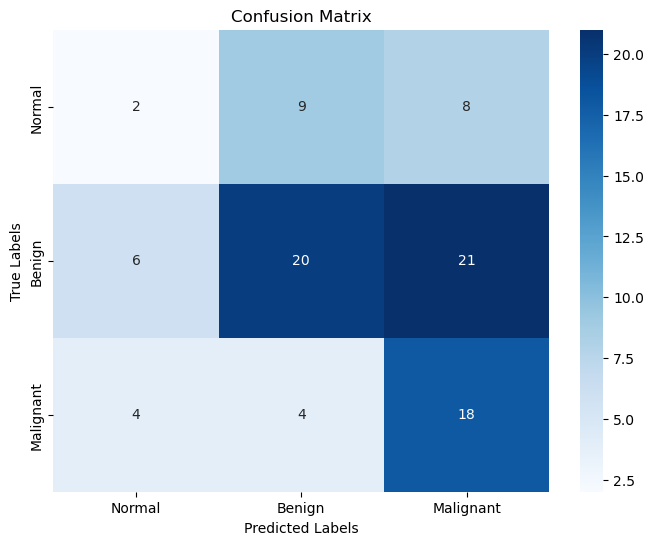

In [355]:
# 加载最优模型
best_model = torch.load('best_model_full.pth',weights_only= False)
best_model.eval()  # 设置为评估模式

# 在测试集上评估模型
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, masks, labels in test_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 存储标签和预测结果以绘制混淆矩阵
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.2f}%")

# Step 3: 计算混淆矩阵
conf_matrix = confusion_matrix(all_labels, all_preds)

# Step 4: 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Benign", "Malignant"], yticklabels=["Normal", "Benign", "Malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

可以看到去除掉有问题的图片后，测试集的准确性反而下降（58% -> 43%），可能由于本来数据集的图像数量较少，去除部分图像后，用于测试，验证和训练的数据更少导致模型的性能下降。

### **Mask2Former(Clean_data)**

In [ ]:
# 训练循环
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, masks in train_loader:
        images = images
        masks = masks
        
        # 模型前向传播
        outputs = model(images)  # 获取掩膜输出
        
        # 计算损失
        loss = criterion(outputs, masks)  # CrossEntropyLoss 需要整数标签
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/20], Loss: 0.2790
Epoch [2/20], Loss: 0.2190
Epoch [3/20], Loss: 0.2051
Epoch [4/20], Loss: 0.1781
Epoch [5/20], Loss: 0.1672
Epoch [6/20], Loss: 0.1598
Epoch [7/20], Loss: 0.1506
Epoch [8/20], Loss: 0.1479
Epoch [9/20], Loss: 0.1454
Epoch [10/20], Loss: 0.1389
Epoch [11/20], Loss: 0.1347
Epoch [12/20], Loss: 0.1315
Epoch [13/20], Loss: 0.1240
Epoch [14/20], Loss: 0.1251
Epoch [15/20], Loss: 0.1282
Epoch [16/20], Loss: 0.1261
Epoch [17/20], Loss: 0.1259
Epoch [18/20], Loss: 0.1213
Epoch [19/20], Loss: 0.1204
Epoch [20/20], Loss: 0.1219


In [384]:
#测试模型
model.eval()  # 设置为评估模式
running_iou = 0.0
running_dice = 0.0
total_samples = 0

with torch.no_grad():  # 不需要梯度计算
    for images, masks in test_loader:
        # 前向传播：获取模型预测结果
        outputs = model(images)  # 输出 (B, num_classes, H, W)

        # 使用最大值分类输出（从概率图中选择每个像素最大概率的类别）
        pred = torch.argmax(outputs, dim=1)  # 获取预测类别 (B, H, W)

        # 计算IoU和Dice系数
        iou = iou_score(pred, masks, 2)
        dice = dice_score(pred, masks, 2)

        running_iou += iou
        running_dice += dice
        total_samples += 1

avg_iou = running_iou / total_samples
avg_dice = running_dice / total_samples

print(f"Average IoU: {avg_iou:.4f}")
print(f"Average Dice Score: {avg_dice:.4f}")


Average IoU: 0.6645
Average Dice Score: 0.7640


对图像数据进行筛选后，Mask2Former进行图像分割的Average IoU: 0.6334 -> 0.6645 ; Average Dice Score: 0.7259 -> 0.7640，发生小幅度提升，说明进行图像分割前进行图像数据的清洗可以提高模型的效果。

# **Reference**

1. Pawłowska, Anna, Piotr Karwat, and Norbert Żołek. Letter to the Editor. Re: “[Dataset of breast ultrasound images by W. Al-Dhabyani, M. Gomaa, H. Khaled & A. Fahmy, Data in Brief, 2020, 28, 104863]. *Data in Brief*, vol. 48, 2023, p. 109247. https://doi.org/10.1016/j.dib.2023.109247.
2. Dosovitskiy, Alexey, et al. "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale." *arXiv preprint arXiv:2010.11929v2* (2021). https://doi.org/10.48550/arXiv.2010.11929.
3. Cheng, B., Misra, I., Schwing, A. G., Kirillov, A., & Girdhar, R. (2022). Masked-attention Mask Transformer for universal image segmentation. In *Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)*.

